In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from scipy import interpolate
import uuid

In [2]:


class GeneticAlgorithm():
    """
    Класс реализующий генетический алгоритм

    ...

    Methods
    -------
    estimate_fitness()
        метод оценки значения приспособленности
    crossover()
        оператор скрещивания
    mutation()
        оператор мутации
    keep_bounds()
        метод для выравнивания значений аргументов по заданным границам
    stop_criterion()
        метод с критериями останова
    run()
        метод для запуска оптимизации
    """
    
    def __init__(self,
                 opt_function,
                 num_args,
                 data,
                 population_size = 100,
                 crossover_rate = 0.5,
                 mutation_probability = 0.05,
                 max_num_iteration = 1e5,
                 max_num_iteration_without_improvement = 10,
                 tolerance = 1e-5,
                 args_bounds = None,
                 c_rating = 0.1
                ):
                 
        """
        Parameters
        ----------
        opt_function : function
            оптимизируемая функция
        num_args : int
            количество аргументов у opt_function
        data : undefined
            данные необходимые для расчетов 
        population_size : int
            количество особей
        crossover_rate : float [0, 1]
            процент скрещивающихся особей
        mutation_probability : float [0, 1]
            вероятность мутации
        max_num_iteration : int or None
            максимальное количество итераций
        max_num_iteration_without_improvement : int
            максимальное количество последовательных итераций без улучшения результата
        tolerance : float
            минимальное значение уменьшения стандартного отклонения от best_score_history,  
            при котором продолжаются расчеты
        args_bounds : None or list of tuples
            содержит кортежи с мин и макс значениями для каждого аргумента opt_function
            если None, тогда выбираются стандартные границы
        c_rating : float [0, 1]
            коэффициент значимости рейтинга (0 - рейтинг выключается, 1 - макс. значимость)
        """
        
        self.opt_function = opt_function
        self.num_args = num_args
        self.data = data
        self.population_size = population_size
        self.crossover_rate = crossover_rate
        self.mutation_probability = mutation_probability
        self.max_num_iteration = int(max_num_iteration)
        self.max_num_iteration_without_improvement = int(max_num_iteration_without_improvement)
        self.tolerance = tolerance
        self.args_bounds = args_bounds
        self.c_rating = c_rating
        
        self.best_score_history = [] # список с историей лучших результатов популяции на каждой итерации
        self.solution_list = [] # список с лучшими решениями и train, test индексами
        
        
    def estimate_fitness(self, x, data):
        """Метод оценивает приспособленность особи
        
        Parameters
        ----------
        x : np.array
            значения аргументов
            
        Returns
        ------
        score : float
            значение функции приспособленности
        """
        score = self.opt_function(x, data)
            
        return score
                 
    def crossover(self, x_parent, y_parent):
        """Метод для случайного скрещивания двух родительских особей, возвращает две потомственные особи
        
        Parameters
        ----------
        x_parent : np.array
            1ая родительская особь
        y_parent : np.array
            2ая родительская особь
            
        Returns
        ------
        x_child : np.array
            1ая потомственная особь
        y_child : np.array
            2ая потомственная особь
        """
        
        x_child = x_parent.copy()
        y_child = y_parent.copy()
                    
        for i in range(self.num_args):
            alpha = np.random.rand()
            x_child[i] = x_parent[i] + alpha * (y_parent[i] - x_parent[i])
            
            alpha = np.random.rand()
            y_child[i] = x_parent[i] + alpha * (x_parent[i] - y_parent[i])
                   
        return x_child, y_child
                 
    
    def mutation(self, x):
        """Метод для мутации особи меняет значения генов случайным образом
        
        Parameters
        ----------
        x : np.array
            значения аргументов
            
        Returns
        ------
        x_new : np.array
            новые значения аргументов        
        """
        
        x_new = x.copy()
        for i in range(self.num_args):
            if self.args_bounds is None:
                alpha = np.random.uniform(-1.0, 1.0)
            else:
                alpha = np.random.uniform(self.args_bounds[i][0], self.args_bounds[i][1])
            x_new[i] = x_new[i] + alpha
            
        return x_new
    
    
    
    def keep_bounds(self, x):
        """Метод ограничивает область значений аргументов
        
        Parameters
        ----------
        x : np.array
            значения аргументов
            
        Returns
        ------
        x_new : np.array
            новые значения аргументов        
        """
        
        x_new = x.copy()
        if self.args_bounds is None:
            return x_new
                       
        for i in range(self.num_args):
            # если x_i меньше минимума, тогда присваиваем значение минимума
            if x_new[i] < self.args_bounds[i][0]:
                x_new[i] = self.args_bounds[i][0]
            # если x_i больше максимума, тогда присваиваем значение максимума
            if x_new[i] > self.args_bounds[i][1]:
                x_new[i] = self.args_bounds[i][1]
            
        return x_new
           
        
    def stop_criterion(self, i):
        """В методе реализованы критерии останова
        
        Parameters
        ----------
        i : int
            номер итерации
            
        Returns
        ------
        True / False
            если хотя бы один из критериев срабатывает, то возвращает True        
        """
            
        # если стандартное отклонение best_score_history уменьшается меньше, чем на tolerance 
        rolling_std = [np.std(self.best_score_history[:i+1]) for i in range(3, len(self.best_score_history))]
        rolling_std = np.array(rolling_std)
        std_change = np.diff(rolling_std)[-1] / rolling_std[-2]
        if std_change < self.tolerance:
            print("std stop-criterion")
            return True
        
        # если количество итераций превышает максимальное
        if i > self.max_num_iteration - 1:
            print("max number of iteration stop-criterion")
            return True
        
        # если best_score не улучшается более max_num_iteration_without_improvement итераций
        n = self.max_num_iteration_without_improvement
        best_score_changes = np.sign(np.diff(self.best_score_history))[-n:]
        if not -1 in best_score_changes:
            print("max number of iteration without improvement stop-criterion")
            return True
            
        return False 
        
        
    def selection(self, population):
        """Метод для отбора особей
        
        Parameters
        ----------
        population : list
            популяция, содержит значения генов всех особей и оценки приспособленности
            
        Returns
        ------
        population : list
            популяция, содержит значения генов всех особей и оценки приспособленности
        """
        
        population = sorted(population, key=lambda item: item['score'])
        population_new = population[:self.population_size]
            
        return population_new
        
        
    def run(self):
        
        # создаем начальную популяцию
        population = []
        for i in range(self.population_size):
            args_individual = np.zeros(self.num_args)
            # нормируем значения аргументов к границам args_bounds, если они заданы
            for n in range(self.num_args):
                if self.args_bounds is None:
                    args_individual[n] = np.random.uniform(-1.0, 1.0)
                else:
                    args_individual[n] = np.random.uniform(self.args_bounds[n][0], self.args_bounds[n][1])
                    
            individual = {'args':args_individual, 'score':None, 'rating':0.0}
            population.append(individual)
           
        
        
        for i_data in range(len(self.data)):
            print(i_data / len(self.data))
            
            df_train = self.data[i_data]['train']
            df_test = self.data[i_data]['test']
            
            stop = False
            i = 0
            # запускаем алгоритм
            while not stop:
#                 print(i)

                # СКРЕЩИВАНИЕ
                parents_population = population[:int(len(population) * self.crossover_rate)]
                childs_population = []
                for x_parent in parents_population:
                    # находим пару для каждой особи и проводим скрещиванием
                    y_parent = np.random.choice(parents_population)
                    x_child_args, y_child_args = self.crossover(x_parent['args'], y_parent['args'])
                    x_child = {'args':x_child_args, 'score':None, 'rating':0.0}
                    y_child = {'args':y_child_args, 'score':None, 'rating':0.0}
                    childs_population.append(x_child)
                    childs_population.append(y_child)
                # добавляем новых потомков в популяцию
                population += childs_population

                # МУТАЦИИ
                for ind, x in enumerate(population):
                    # проверяем условие вероятности мутации
                    if np.random.rand() < self.mutation_probability:
                        population[ind]['args'] = self.mutation(x['args'])

                # ОЦЕНКА ПРИСПОСОБЛЕННОСТИ
                for ind in range(len(population)):
                    population[ind]['args'] = self.keep_bounds(population[ind]['args'])
                    population[ind]['score'] = self.estimate_fitness(population[ind]['args'], df_train)
                    # учитываем рейтинг особи в оценке приспособленнсоти
                    population[ind]['score'] += population[ind]['rating']

                # ОТБОР
                population = self.selection(population)
                
                # записываем best_score 
                best_score = population[0]['score']
                self.best_score_history.append(best_score)

#                 print(population[0])
                if i > 10:
                    stop = self.stop_criterion(i)

                i += 1
                
                
            # Рейтинг
            for ind in range(len(population)):
                population[ind]['rating'] += population[ind]['score'] * self.c_rating

            solution = {
                "individual": population[0],
                "train_index":df_train.index,
                "test_index":df_test.index
            }
            self.solution_list.append(solution)
            

In [3]:
def stupid_backtest_2(df, comm_level=0.02/100):
    """В функции реализован простейший бэктест
        но уже с учетом комиссий
        
        Parameters
        ----------
        df : pd.DataFrame
            датафрейм содержащий ряды signal и Close
        comm_level : float
            уровень комиссий
            
        Returns
        ------
        df : pd.DataFrame
            исходный датафрейм с пнлем с коммиссиями и без
    """
    
    df['pnl'] = (df['Close_n'].diff() * df['signal'].shift()).cumsum()
    df['comm'] = (comm_level * df['Close'] * df['signal'].diff().abs()).cumsum()
    df['pnl_comm'] = df['pnl'] - df['comm']
    
    return df


# переписать функционал!!!

def opt_vix_0(x, df):    
    """Функционал для оптимизации
        
        Parameters
        ----------
        x : np.array
            значения аргументов, по которым рассчитывается значение функционала
        df : pd.DataFrame
            датафрейм содержащий ряды signal_{}, Close и Close_n
            
        Returns
        ------
        f : float
            значение функционала
        """

    df['signal'] = 0.
    for i in range(len(x)):
        signal_name = 'signal_{}'.format(i)
        df['signal'] += x[i] * df[signal_name] 
        
    df = stupid_backtest_2(df)
    
    # "колхозный" шарп
    ret = df['pnl_comm'].diff()
    f = - ret.mean() / ret.std()
    
    return f

In [4]:
def get_pivot(df, p, norm=False):
    
    if p == 'year':
        pv = pd.pivot_table(df, index=df.index.dayofyear, columns=df.index.year,
                            values=df.columns[0], aggfunc='mean')
        
        pv.ffill(limit=10, inplace=True)
        pv = pv.iloc[3:-1]

        index = ["{0} {1}".format(pv.columns[-1], pv.index[i]) for i in range(len(pv))]
        pv.index = pd.to_datetime(index, format='%Y %j')
        
    if p == 'day':
        df = df.between_time('9:30','16:00')
        pv = pd.pivot_table(df, index=60*df.index.hour + df.index.minute, columns=df.index.day+df.index.year*1000,
                            values=df.columns[0], aggfunc='mean')
    
    if p == 'week':
        pv = pd.pivot_table(df, index=df.index.dayofweek, columns=df.index.year*100 + df.index.week,
                            values=df.columns[0], aggfunc='mean')
        pv = pv.iloc[:-1]
        
    if p == 'month':
        pv = pd.pivot_table(df, index=df.index.day, columns=df.index.year*100 + df.index.month,
                            values=df.columns[0], aggfunc='mean')
    

    pv.dropna(how='all', axis=0, inplace=True)
    pv.dropna(how='all', axis=1, inplace=True)
    
    if norm:
        pv = pv.subtract(pv.median(), axis=1)
    pv['median'] = pv.median(axis=1)
    pv['std'] = pv.std(axis=1)
    return pv

In [5]:

import pickle

with open('vix.dat', 'rb') as f:
    dfs = pickle.load(f)

df = dfs['base'][['Close', 'Close_n']].dropna()



    

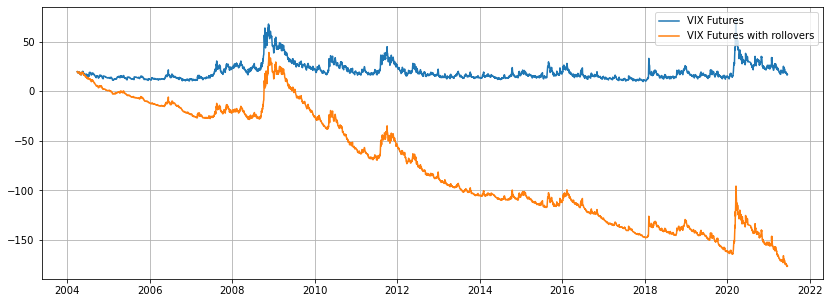

In [6]:
plt.figure(figsize=(14,5))
plt.plot(df['Close'], label='VIX Futures')
plt.plot(df['Close_n'], label='VIX Futures with rollovers')
plt.grid()
plt.legend(loc='upper right')
plt.show()


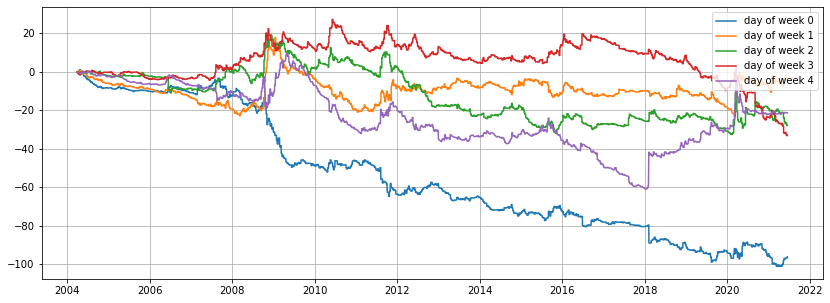

In [7]:
df['index'] = df.index.dayofweek

plt.figure(figsize=(14,5))

for i in [0,1,2,3,4]:
    signal_name = 'signal_dow_{}'.format(i)
    df[signal_name] = 0
    df.loc[df['index'] == i, signal_name] = 1
    
    df['pnl'] = (df['Close_n'].diff() * df[signal_name].shift()).cumsum()
    
    plt.plot(df['pnl'], label='day of week {}'.format(i))
    
plt.grid()
plt.legend(loc='upper right')
plt.show()


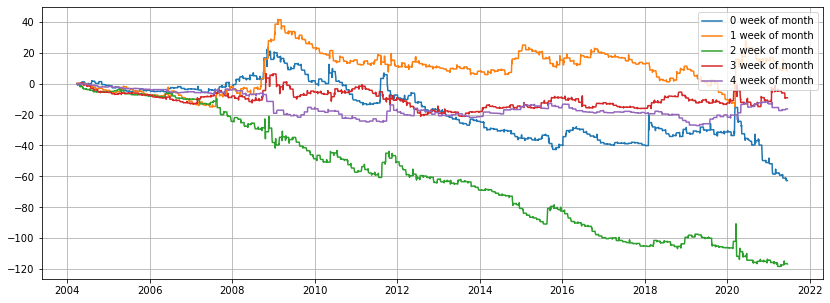

In [8]:
df['index'] = df.index.day


plt.figure(figsize=(14,5))
    
for n_week in range(0, 5):
    
    
    signal_name = 'signal_week_{}'.format(n_week)
    df[signal_name] = 0


    
    for i in range(1,8):
        n_day = n_week * 7 + i

        df.loc[df['index'] == n_day, signal_name] = 1

    df['pnl'] = (df['Close_n'].diff() * df[signal_name].shift()).cumsum()

    plt.plot(df['pnl'], label='{} week of month'.format(n_week))

plt.grid()
plt.legend(loc='upper right')
plt.show()


del df['index'], df['pnl']

In [9]:
df.columns = ['Close', 'Close_n'] + ['signal_{}'.format(i) for i in range(len(df.columns) - 2)]

df['index'] = df.index.year * 100 + df.index.month
my_list = (df['index']).unique()
my_list.sort()

data = []
for my in my_list[1:]:
    df_train = df.loc[:df.loc[df['index'] == my].index[0]]
    df_train = df_train.iloc[:-1]
    df_test = df.loc[df['index'] == my]

    if len(df_train) > 2 * len(df_test):
        data.append({"train":df_train, "test":df_test})
        

In [10]:
args_bounds = [[-1, 1] for _ in range(len(df.columns)-3)]

ga = GeneticAlgorithm(opt_vix_0, len(args_bounds), data, 
                      args_bounds=args_bounds, 
                      population_size = 100,
                      max_num_iteration_without_improvement=5,
                      mutation_probability=0.5)
ga.run()



0.0
std stop-criterion
0.004878048780487805
max number of iteration without improvement stop-criterion
0.00975609756097561
std stop-criterion
0.014634146341463415
std stop-criterion
0.01951219512195122
max number of iteration without improvement stop-criterion
0.024390243902439025
max number of iteration without improvement stop-criterion
0.02926829268292683
std stop-criterion
0.03414634146341464
std stop-criterion
0.03902439024390244
std stop-criterion
0.04390243902439024
std stop-criterion
0.04878048780487805
std stop-criterion
0.05365853658536585
max number of iteration without improvement stop-criterion
0.05853658536585366
std stop-criterion
0.06341463414634146
std stop-criterion
0.06829268292682927
std stop-criterion
0.07317073170731707
std stop-criterion
0.07804878048780488
std stop-criterion
0.08292682926829269
std stop-criterion
0.08780487804878048
std stop-criterion
0.09268292682926829
std stop-criterion
0.0975609756097561
std stop-criterion
0.1024390243902439
std stop-criteri

std stop-criterion
0.775609756097561
std stop-criterion
0.7804878048780488
std stop-criterion
0.7853658536585366
std stop-criterion
0.7902439024390244
std stop-criterion
0.7951219512195122
std stop-criterion
0.8
std stop-criterion
0.8048780487804879
std stop-criterion
0.8097560975609757
std stop-criterion
0.8146341463414634
std stop-criterion
0.8195121951219512
std stop-criterion
0.824390243902439
std stop-criterion
0.8292682926829268
std stop-criterion
0.8341463414634146
std stop-criterion
0.8390243902439024
std stop-criterion
0.8439024390243902
std stop-criterion
0.848780487804878
std stop-criterion
0.8536585365853658
std stop-criterion
0.8585365853658536
std stop-criterion
0.8634146341463415
std stop-criterion
0.8682926829268293
std stop-criterion
0.8731707317073171
std stop-criterion
0.8780487804878049
std stop-criterion
0.8829268292682927
std stop-criterion
0.8878048780487805
std stop-criterion
0.8926829268292683
std stop-criterion
0.8975609756097561
std stop-criterion
0.902439024

No handles with labels found to put in legend.


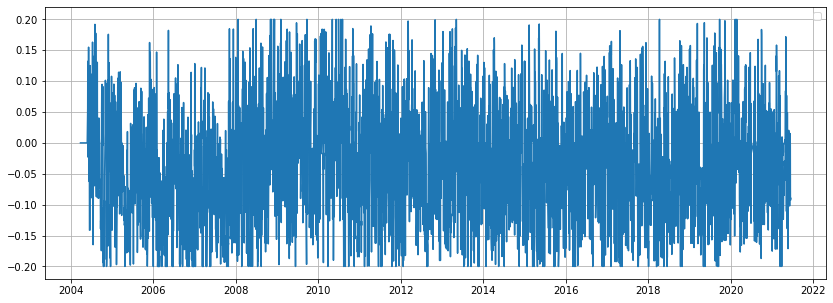

No handles with labels found to put in legend.


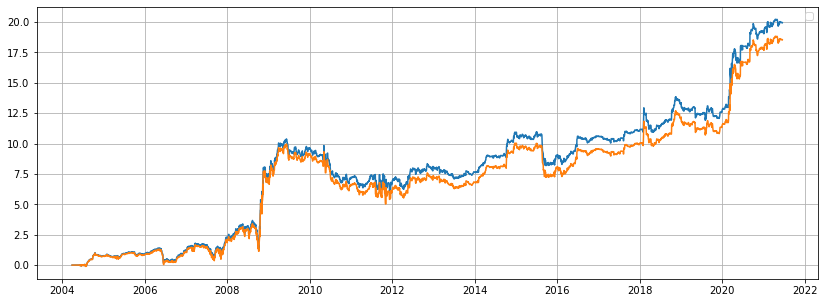

In [11]:
df['signal'] = 0.


for solution in ga.solution_list:

    test_index = solution['test_index']
    x = solution['individual']['args']

    for i in range(len(x)):
        signal_name = 'signal_{}'.format(i)
        df.loc[test_index, 'signal'] += x[i] * df.loc[test_index, signal_name]


df['signal'] = df['signal'] / len(x)


plt.figure(figsize=(14,5))
plt.plot(df['signal'])
plt.grid()
plt.legend(loc='upper right')
plt.show()


df = stupid_backtest_2(df)


plt.figure(figsize=(14,5))
plt.plot(df['pnl'])
plt.plot(df['pnl_comm'])
plt.grid()
plt.legend(loc='upper right')
plt.show()
